# Baby boy/girl classifier model preparation

*based on: Francisco Ingham and Jeremy Howard. Inspired by [Adrian Rosebrock](https://www.pyimagesearch.com/2017/12/04/how-to-create-a-deep-learning-dataset-using-google-images/)*

*by: Artyom Vorobyov*

Notebook execution and model training is made in Google Colab

In [1]:
from fastai.vision import *
from pathlib import Path

## Get a list of URLs

### How to get a dataset from Google Images

Go to [Google Images](http://images.google.com) and search for the images you are interested in. The more specific you are in your Google Search, the better the results and the less manual pruning you will have to do.

Scroll down until you've seen all the images you want to download, or until you see a button that says 'Show more results'. All the images you scrolled past are now available to download. To get more, click on the button, and continue scrolling. The maximum number of images Google Images shows is 700.

It is a good idea to put things you want to exclude into the search query, for instance if you are searching for the Eurasian wolf, "canis lupus lupus", it might be a good idea to exclude other variants:

    "canis lupus lupus" -dog -arctos -familiaris -baileyi -occidentalis

You can also limit your results to show only photos by clicking on Tools and selecting Photos from the Type dropdown.

### How to download image URLs

Now you must run some Javascript code in your browser which will save the URLs of all the images you want for you dataset.

Press <kbd>Ctrl</kbd><kbd>Shift</kbd><kbd>J</kbd> in Windows/Linux and <kbd>Cmd</kbd><kbd>Opt</kbd><kbd>J</kbd> in Mac, and a small window the javascript 'Console' will appear. That is where you will paste the JavaScript commands.

You will need to get the urls of each of the images. Before running the following commands, you may want to disable ad blocking extensions (uBlock, AdBlockPlus etc.) in Chrome. Otherwise the window.open() command doesn't work. Then you can run the following commands:

```javascript
urls = Array.from(document.querySelectorAll('.rg_di .rg_meta')).map(el=>JSON.parse(el.textContent).ou);
window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));
```

### What to do with babies

For this particular application (baby boy/girl classifier) you can just search for "baby boys" and "baby girls". Then run the script mentioned above and save the URLs in "boys_urls.csv" and "girls_urls.csv".

### Create directory and upload urls file into your server

In [2]:
class_boy = 'boys'
class_girl = 'girls'
classes = [class_boy, class_girl]
path = Path('./data')
data_sources = [
    ('./boys_urls.csv', path/'train'/class_boy),
    ('./girls_urls.csv', path/'train'/class_girl)
]

## Download images

fast.ai has a function that allows you to do just that. You just have to specify the urls filename as well as the destination folder and this function will download and save all images that can be opened. If they have some problem in being opened, they will not be saved.

Let's download our images! Notice you can choose a maximum number of images to be downloaded. In this case we will not download all the urls.

In [3]:
# Download the images listed in URL's files
for urls_path, dest_path in data_sources:
    dest = Path(dest_path)
    dest.mkdir(parents=True, exist_ok=True)
    download_images(urls_path, dest, max_pics=800)
    # If you have problems download, try the code below with `max_workers=0` to see exceptions:
    # download_images(urls_path, dest, max_pics=20, max_workers=0)

Then we can remove any images that can't be opened:

In [4]:
for _, dest_path in data_sources:
    verify_images(dest_path, delete=True, max_size=800)

## Cleaning the data

Now it's a good moment to review the downloaded images and clean them. There will be some non-relevant images - photos of adults, photos of the baby clothes without the babies etc. Just review the images and remove non-relevant ones. For 2x400 images it'll take just 10-20 minutes in total.

There's also another way to clean the data - use the `fastiai.widgets.ImageCleaner`. It's used after you've trained your model. Even if you plan to use `ImageCleaner` later - it still makes sense to review the dataset briefly by yourself at the beginning.

## Load the data

In [5]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train="train", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

Good! Let's take a look at some of our pictures then.

In [6]:
# Check if all the classes were correctly read
print(data.classes)
print(data.classes == classes)

['boys', 'girls']
True


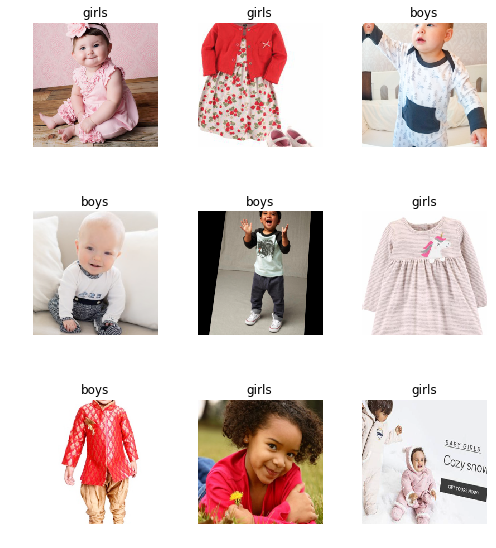

In [7]:
data.show_batch(rows=3, figsize=(7,8), ds_type=DatasetType.Train)

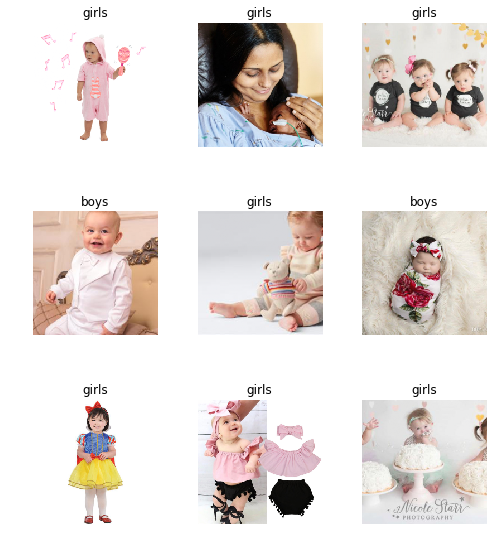

In [8]:
data.show_batch(rows=3, figsize=(7,8), ds_type=DatasetType.Valid)

In [9]:
print("Train set size: {}. Validation set size: {}".format(len(data.train_ds), len(data.valid_ds)))

Train set size: 592. Validation set size: 147


## Train model

In [10]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

In [11]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time


RuntimeError: DataLoader worker (pid(s) 65641) exited unexpectedly

In [ ]:
learn.save('stage-1')

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()

In [ ]:
# If the plot is not showing try to give a start and end learning rate
# learn.lr_find(start_lr=1e-5, end_lr=1e-1)
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(2, max_lr=slice(1e-5,1e-3))

In [ ]:
learn.save('stage-2')

## Interpretation

In [ ]:
learn.load('stage-2');

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.plot_confusion_matrix()

## Putting your model in production

First thing first, let's export the content of our `Learner` object for production:

In [ ]:
export_path = Path("../backend/ai_models/export.pkl")
# ensure folder exists
export_path.parents[0].mkdir(parents=True, exist_ok=True)
# absolute path is passed as learn object attaches relative path to it's data folder rather than to notebook folder
learn.export(export_path.absolute())

This will create a file named 'export.pkl' in the given directory. This exported model contains everything we need to deploy our model (the model, the weights but also some metadata like the classes or the transforms/normalization used).